<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Simulation-3" data-toc-modified-id="Simulation-3-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Simulation 3</a></span></li><li><span><a href="#Simulation-4" data-toc-modified-id="Simulation-4-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Simulation 4</a></span></li><li><span><a href="#Comparison-to-ANCOMBC-and-DESeq2-like" data-toc-modified-id="Comparison-to-ANCOMBC-and-DESeq2-like-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Comparison to ANCOMBC and DESeq2-like</a></span></li><li><span><a href="#Household-simulations" data-toc-modified-id="Household-simulations-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Household simulations</a></span></li></ul></div>

In [1]:
# This block is just for importing the necessary libraries.  
import os
from collections import defaultdict
# Numerical libraries
import pandas as pd
import numpy as np
import biom
import arviz as az
from scipy.spatial.distance import euclidean
from gneiss.balances import sparse_balance_basis
# Plotting libraries
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patches as mpatches
import seaborn as sns
from matplotlib_venn import venn2, venn3
from matplotlib.ticker import MaxNLocator
# custom utility and plotting functions
from util import (extract_differentials, select_features, 
                  get_genomic_data, collapse_transcripts, 
                  aggregate_pathways,
                  ranking, btest, log_pvalue, read_kegg_dict,
                  ilr_transform_differentials,
                  rename_clades, create_projection,
                  match_all_differentials,
                  match_all_differentials_and_tree)
from plot import (rankplot, networkplot, vectorplot)
from scipy.stats import pearsonr
import random

# directory paths
amp_directory = '../sfari/data/sra/Combined'
wgs_directory = '../sfari/data/sra_shotgun/Combined'
rna_directory = '../sfari/data/recount3'
kang_directory = '../sfari/data/sra/Kang2017'
sepp_directory = '../sfari/data/sra/Kang2017/deblur/sepp-v2'
results_dir = '../results'
kegg_dir = f'{results_dir}/kegg'
hsa_dir = f'{results_dir}/hsa_kegg'
np.random.seed(0)
random.seed(0)
%matplotlib inline

# Simulation 3

In [2]:
# load 16S, whole genome shotgun and RNAseq data
posterior_name = 'age_sex_matched_posterior'
amp_fname = f'{amp_directory}/{posterior_name}/amp_differentials-simulated3.nc'
sim_diffs = extract_differentials(amp_fname)

amp_fname = f'{kang_directory}/week0_ogu/differentials-v8.nc'
true_diffs = extract_differentials(amp_fname)

# load taxonomy
taxonomy = pd.read_table('~/databases/wol/taxonomy/ranks.tsv', 
                         index_col=0)
taxid = pd.read_table('~/databases/wol/taxonomy/taxid.map', 
                      header=None, dtype=str)
taxid.columns = ['GOTU', 'genome']
mapping = pd.merge(taxid, taxonomy, left_on='GOTU', right_index=True)
mapping = mapping.set_index('genome')

In [3]:
sim_diffs.index = true_diffs.index

Text(0, 0.5, 'Estimated mean log-fold change')

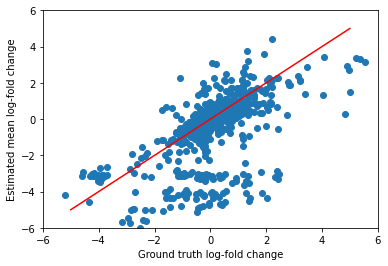

In [4]:
plt.scatter(true_diffs.mean(axis=1), sim_diffs.mean(axis=1), zorder=0)
plt.plot(np.linspace(-5, 5), np.linspace(-5, 5), 'r', zorder=1)
plt.xlim([-6, 6])
plt.ylim([-6, 6])
plt.xlabel('Ground truth log-fold change')
plt.ylabel('Estimated mean log-fold change')

Text(0, 0.5, 'Estimated log-fold change')

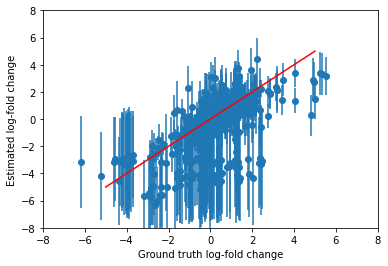

In [5]:
plt.errorbar(true_diffs.mean(axis=1), sim_diffs.mean(axis=1), yerr=sim_diffs.std(axis=1), 
             zorder=0, fmt='o')
plt.plot(np.linspace(-5, 5), np.linspace(-5, 5), 'r', zorder=1)
plt.xlim([-8, 8])
plt.ylim([-8, 8])
plt.xlabel('Ground truth log-fold change')
plt.ylabel('Estimated log-fold change')

In [6]:
from scipy.stats import spearmanr
spearmanr(true_diffs.mean(axis=1), sim_diffs.mean(axis=1))

SpearmanrResult(correlation=0.6485174500524037, pvalue=6.468275014580531e-106)

Text(0, 0.5, 'Estimated log-fold change')

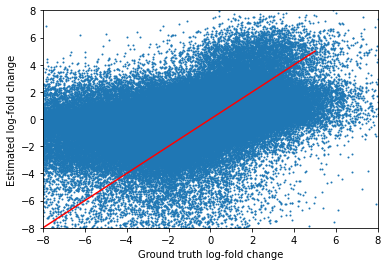

In [7]:
plt.scatter(sim_diffs.values.ravel(), true_diffs.values.ravel(), s=1)
plt.plot(np.linspace(-10, 5), np.linspace(-10, 5), 'r')
plt.xlim([-8, 8])
plt.ylim([-8, 8])
plt.xlabel('Ground truth log-fold change')
plt.ylabel('Estimated log-fold change')

In [8]:
spearmanr(sim_diffs.values.ravel(), true_diffs.values.ravel())

SpearmanrResult(correlation=0.47308588181688693, pvalue=0.0)

In [9]:
def rankplot(diffs, ax):
    lo = np.percentile(diffs.values, axis=1, q=5)
    hi = np.percentile(diffs.values, axis=1, q=95)
    index = np.arange(len(diffs))
    ax.fill_between(index, lo, hi, fc='b', label='Estimated')
    ax.set_ylabel('Log fold change')
    plt.xlabel('Microbes')

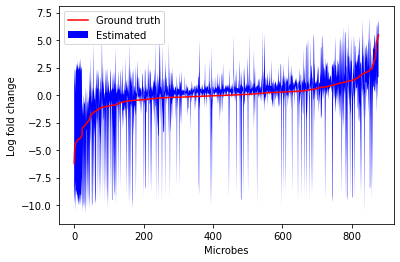

In [10]:
x = np.arange(len(sim_diffs))

ytrue = true_diffs.mean(axis=1)
ytrue = ytrue - ytrue.mean()
ytrue = ytrue.sort_values()

#sim_diffs = sim_diffs.loc[ytrue.index]
sim_diffs = sim_diffs - sim_diffs.mean(axis=0).values
yerr = sim_diffs.std(axis=1)

fig, ax = plt.subplots()
rankplot(sim_diffs.loc[ytrue.index], ax)
plt.plot(x, ytrue, '-', zorder=1, markersize=1, c='r', label='Ground truth')
plt.legend()
#y = sim_diffs.mean(axis=1)
#plt.errorbar(x, y, yerr=2*yerr, fmt="o", zorder=0, color='b')
#plt.plot(x, ytrue, 'o', zorder=1, markersize=1, c='r')
#plt.xlabel('Microbes')
#plt.ylabel('Log fold change')

In [11]:
table = biom.load_table('../sfari/data/sra/Combined/simulated3.biom')

In [12]:
totals = pd.Series(table.sum(axis='observation'), index=table.ids(axis='observation'))

Text(0, 0.5, 'Mean log fold change')

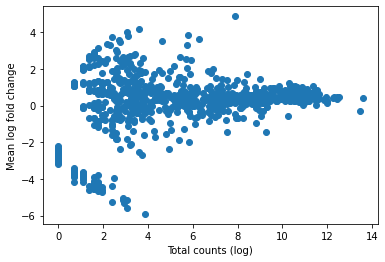

In [13]:
plt.scatter(np.log(totals + 1), sim_diffs.mean(axis=1))
plt.xlabel('Total counts (log)')
plt.ylabel('Mean log fold change')

Text(0, 0.5, 'Std dev log fold change')

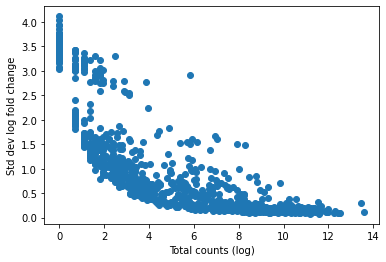

In [14]:
plt.scatter(np.log(totals + 1), sim_diffs.std(axis=1))
plt.xlabel('Total counts (log)')
plt.ylabel('Std dev log fold change')

Text(0.5, 0, 'Log fold change')

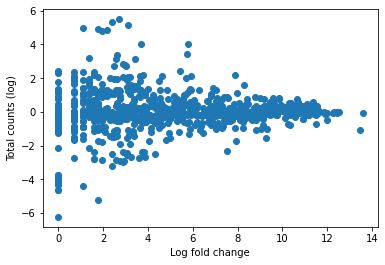

In [15]:
plt.scatter(np.log(totals + 1), ytrue.loc[sim_diffs.index])
plt.ylabel('Total counts (log)')
plt.xlabel('Log fold change')

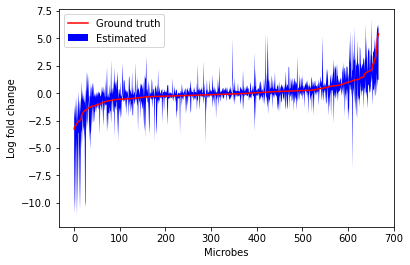

In [16]:
idx = totals.loc[np.log(totals + 1) > 2].index

ytrue = true_diffs.mean(axis=1).loc[idx]
ytrue = ytrue - ytrue.mean()
ytrue = ytrue.sort_values()

sim_diffs = sim_diffs.loc[ytrue.index]
sim_diffs = sim_diffs - sim_diffs.mean(axis=0).values
yerr = sim_diffs.std(axis=1)

x = np.arange(len(ytrue))

fig, ax = plt.subplots()
rankplot(sim_diffs, ax)
plt.plot(x, ytrue, '-', zorder=1, markersize=1, c='r', label='Ground truth')
plt.legend()
#y = sim_diffs.mean(axis=1)
#plt.errorbar(x, y, yerr=2*yerr, fmt="o", zorder=0, color='b')
#plt.plot(x, ytrue, 'o', zorder=1, markersize=1, c='r')
#plt.xlabel('Microbes')
#plt.ylabel('Log fold change')

# Simulation 4

With differential sequencing depth

In [17]:
posterior_name = 'age_sex_matched_posterior'
amp_fname = f'{amp_directory}/{posterior_name}/amp_differentials-simulated4.nc'
sim_diffs = extract_differentials(amp_fname)

sim_diffs.index = true_diffs.index

(-9.0, 9.0)

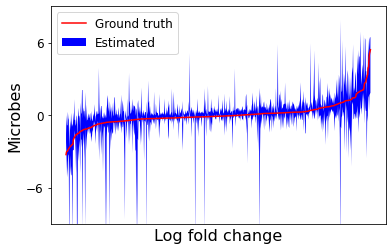

In [18]:
idx = totals.loc[np.log(totals + 1) > 2].index

ytrue = true_diffs.mean(axis=1).loc[idx]
ytrue = ytrue - ytrue.mean()
ytrue = ytrue.sort_values()

sim_diffs = sim_diffs.loc[ytrue.index]
sim_diffs = sim_diffs - sim_diffs.mean(axis=0).values
yerr = sim_diffs.std(axis=1)

x = np.arange(len(ytrue))

fig, ax = plt.subplots(figsize=(6, 4))
rankplot(sim_diffs, ax)
ax.plot(x, ytrue, '-', zorder=1, markersize=1, c='r', label='Ground truth')
ax.legend(loc=2, fontsize=12)
ax.set_xticks([])
ax.tick_params(axis='y', labelsize=12)
ax.set_xlabel('Log fold change', fontsize=16)
ax.set_ylabel('Microbes', fontsize=16)
locator = MaxNLocator(prune='both', nbins=3)
ax.yaxis.set_major_locator(locator)
ax.set_ylim([-9, 9])
#y = sim_diffs.mean(axis=1)
#plt.errorbar(x, y, yerr=2*yerr, fmt="o", zorder=0, color='b')
#plt.plot(x, ytrue, 'o', zorder=1, markersize=1, c='r')
#plt.xlabel('Microbes')
#plt.ylabel('Log fold change')

# Comparison to ANCOMBC and DESeq2-like

In [19]:
import pandas as pd
import arviz as az

dirpath = '../sfari/data/sra/Combined'
ancombc_out = 'ancom.output.summary-v3.txt'
ancombc_out = f'{dirpath}/{ancombc_out}'
ancom_lfc = pd.read_csv(ancombc_out, index_col=0)
ancom_lfc.index = list(map(str, ancom_lfc.index))

deseq2_out = f'{dirpath}/deseq2_like.nc'
deseq2_diffs = az.from_netcdf(deseq2_out)

deseq2_diffs = deseq2_diffs.posterior.beta.to_dataframe()
deseq2_diffs = pd.pivot(deseq2_diffs.reset_index(), index='feature', columns=['chain', 'draw'])

In [20]:
match_diff = sim_diffs.median(axis=1)
match_diff = match_diff.loc[ancom_lfc.index]

group_diff = deseq2_diffs.median(axis=1)
group_diff = group_diff.loc[ancom_lfc.index]

ytrue = ytrue.loc[ancom_lfc.index]

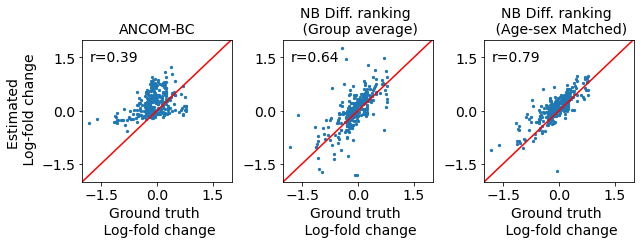

In [21]:
fig, ax = plt.subplots(1, 3, figsize=(9, 3.5))
ax[0].scatter(ytrue, ancom_lfc['cc_bool_beta'], s=5)
ax[1].scatter(ytrue, group_diff, s=5)
ax[2].scatter(ytrue, match_diff, s=5)

ancom_r = pearsonr(ytrue, ancom_lfc['cc_bool_beta'])
group_r = pearsonr(ytrue, group_diff)
match_r = pearsonr(ytrue, match_diff)

fs = 14
ls = 14
rs = [ancom_r, group_r, match_r]
titles = ['ANCOM-BC', 'NB Diff. ranking \n (Group average)', 'NB Diff. ranking \n (Age-sex Matched)']
for i, a in enumerate(ax):
    a.set_ylim([-2, 2])
    a.set_xlim([-2, 2])
    r = np.round(rs[i][0], 2)
    text = f'r={r}'
    a.annotate(text, xy=(-1.8, 1.4), fontsize=fs)
    a.plot([-2, 2], [-2, 2], 'r')
    a.set_title(titles[i], fontsize=fs)    
    a.set_xlabel('Ground truth \n Log-fold change', fontsize=fs)

    a.tick_params(axis='x', labelsize=ls)
    a.tick_params(axis='y', labelsize=ls)

    locator = MaxNLocator(prune='both', nbins=3)
    a.xaxis.set_major_locator(locator)
    a.yaxis.set_major_locator(locator)
ax[0].set_ylabel('Estimated \n Log-fold change', fontsize=fs)

plt.tight_layout()

# Household simulations

In [143]:
posterior_name = 'age_sex_matched_posterior'
amp_fname = f'{amp_directory}/{posterior_name}/amp_household-simulated5.nc'
amp_fname = f'{amp_directory}/{posterior_name}/amp_age_sex-relaxed-simulated5.nc'
household_diffs = extract_differentials(amp_fname)
household_diffs.index = true_diffs.index
household_md = pd.read_table(f'{amp_directory}/simulated5_houseshold_metadata.txt', index_col=0)

amp_fname = f'{amp_directory}/{posterior_name}/amp_age_sex-simulated5.nc'
agesex_diffs = extract_differentials(amp_fname)
agesex_diffs.index = true_diffs.index
agesex_md = pd.read_table(f'{amp_directory}/simulated5_agesex_metadata.txt', index_col=0)

table = biom.load_table('../sfari/data/sra/Combined/simulated5.biom').to_dataframe().T
household_table = table.loc[household_md.index]
agesex_table = table.loc[agesex_md.index]

Look at medians

In [146]:
household_taxa = set(household_table.loc[:, household_table.sum(axis=0) > 10].columns)
household_diffs = household_diffs.median(axis=1)
household_diffs = household_diffs.loc[household_taxa & set(ytrue.index)]

agesex_taxa = set(agesex_table.loc[:, agesex_table.sum(axis=0) > 10].columns)
agesex_diffs = agesex_diffs.median(axis=1)
agesex_diffs = agesex_diffs.loc[agesex_taxa & set(ytrue.index)]

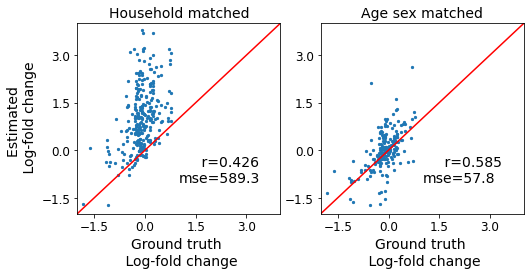

In [174]:
fs = 14
ls = 12

fig, ax = plt.subplots(1, 2, figsize=(8, 3.5))
ax[0].scatter(ytrue.loc[household_diffs.index], household_diffs, s=5)
ax[1].scatter(ytrue.loc[agesex_diffs.index], agesex_diffs, s=5)
xx = np.linspace(-2, 5)
ax[0].plot(xx, xx, 'r')
ax[1].plot(xx, xx, 'r')
ax[0].set_title('Household matched', fontsize=fs)
ax[1].set_title('Age sex matched', fontsize=fs)

r, p = pearsonr(ytrue.loc[household_diffs.index], household_diffs)
r = np.round(r, 3)
mse = np.round(np.sum(((ytrue - household_diffs)**2)), 1)
text = f'     r={r}\nmse={mse}'
ax[0].annotate(text, xy=(1, -1), fontsize=fs)
ax[0].set_xlim([-2, 5])
ax[0].set_ylim([-2, 4])

r, p = pearsonr(ytrue.loc[agesex_diffs.index], agesex_diffs)
r = np.round(r, 3)
mse = np.round(np.sum(((ytrue - agesex_diffs)**2)), 1)
text = f'     r={r}\nmse={mse}'
ax[1].annotate(text, xy=(1, -1), fontsize=fs)
ax[0].set_ylabel('Estimated \n Log-fold change', fontsize=fs)

for i, a in enumerate(ax):
    a.set_xlim([-2, 4])
    a.set_ylim([-2, 4])
    a.set_xlabel('Ground truth \n Log-fold change', fontsize=fs)

    a.tick_params(axis='x', labelsize=ls)
    a.tick_params(axis='y', labelsize=ls)

    locator = MaxNLocator(prune='both', nbins=4)
    a.xaxis.set_major_locator(locator)
    a.yaxis.set_major_locator(locator)

/mnt/home/jmorton/miniconda3/envs/qiime2-2021.4/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/mnt/home/jmorton/miniconda3/envs/qiime2-2021.4/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


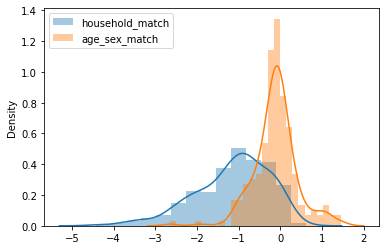

In [148]:
sns.distplot(ytrue - household_diffs, label='household_match')
sns.distplot(ytrue - agesex_diffs, label='age_sex_match')
plt.legend()

(589.3106869696059, 57.846947630372895)